## Step 1: Create Dataset

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [17]:

small_ds= "gwas.csv"
df = pd.read_csv(small_ds)
df.head()
feature_names = list(df.drop('classes', axis=1).columns)

X = np.array(df.drop('classes', axis=1))
y = np.array(df.classes)

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

In [18]:
### View the data
print("X shape:", X_train.shape)
print("Y example:", Y_train.shape)
print("X example:")
print("\t", feature_names)
print("\t", X_train[0])
print("Y example:")
# print("\t", classes)
print("\t", Y_train[0])

X shape: (500, 1000)
Y example: (500, 2)
X example:
	 ['main1', 'main2', 'main3', 'main4', 'main5', 'main6', 'main7', 'main8', 'main9', 'main10', 'main11', 'main12', 'main13', 'main14', 'main15', 'main16', 'main17', 'main18', 'main19', 'main20', 'main21', 'main22', 'main23', 'main24', 'main25', 'main26', 'main27', 'main28', 'main29', 'main30', 'main31', 'main32', 'main33', 'main34', 'main35', 'main36', 'main37', 'main38', 'main39', 'main40', 'main41', 'main42', 'main43', 'main44', 'main45', 'main46', 'main47', 'main48', 'main49', 'main50', 'main51', 'main52', 'main53', 'main54', 'main55', 'main56', 'main57', 'main58', 'main59', 'main60', 'main61', 'main62', 'main63', 'main64', 'main65', 'main66', 'main67', 'main68', 'main69', 'main70', 'main71', 'main72', 'main73', 'main74', 'main75', 'main76', 'main77', 'main78', 'main79', 'main80', 'main81', 'main82', 'main83', 'main84', 'main85', 'main86', 'main87', 'main88', 'main89', 'main90', 'main91', 'main92', 'main93', 'main94', 'main95', 'mai

## Step 3: Perform Feature Importance Ranking with L1 Regularization

In [19]:
### Plot training and validation accuracy and loss over time
def plot_history(history):

  # Extract accuracy and loss values (in list form) from the history
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Create a list of epoch numbers
  epochs = range(1, len(acc) + 1)

  # Plot training and validation loss values over time
  plt.figure(figsize=(5, 2))
  plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
  plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  # Plot training and validation accuracies over time
  plt.figure(figsize=(5, 2))
  plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
  plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

In [20]:
### Plot ROC curve
def plot_roc(model, X_test, Y_test):

  # Set up figure
  plt.figure(figsize=(3, 3))
  plt.plot([0, 1], [0, 1], 'k--')
  
  # Run inference
  Y_pred = model.predict(X_test)
  fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
      
  # Plot
  plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model", auc(fpr, tpr)))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend()
  plt.show()

In [21]:
### Generate feature importance rankings
def score_features(model):
  
  # Get weights (without the bias terms)
  weights = model.layers[0].get_weights()[0]

  # Take RMS of each set of weights (i.e. weights feeding into nodes for each feature)
  rms = np.sqrt(np.sum(np.square(weights), axis=1) / weights.shape[1])

  # Normalize the RMS scores
  norm_rms = rms / np.sum(rms)

  # Sort features by importance ranking (RMS)
  zip_features = zip(feature_names, rms, norm_rms)
  zip_features = sorted(zip_features, key = lambda x: x[1], reverse=True)

  # Print feature importance
  print("Feature importance (highest to lowest)")
  print("Feature name\t:\tRMS value\t:\tNormalized RMS")
  for name, rms, norm_rms in zip_features:
    print(name, "\t:\t", rms, "\t:\t", norm_rms)

In [22]:
### Build model

# Settings
bias = True
kernel_reg = tf.keras.regularizers.L1(0.1)
bias_reg = tf.keras.regularizers.L1(0.1)
activity_reg = None

# Get dimensions
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

# First layer: adjust the regularizers for feature importance
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4,
                                input_dim=n_features, 
                                use_bias=bias,
                                kernel_regularizer=kernel_reg,
                                bias_regularizer=bias_reg,
                                activity_regularizer=activity_reg,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Second layer
model.add(tf.keras.layers.Dense(4,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Output layer
model.add(tf.keras.layers.Dense(n_classes,
                                activation='softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary and first layer weights
print(model.summary())
print("First layer weights:", model.layers[0].get_weights())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 4004      
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dropout_3 (Dropout)         (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 4034 (15.76 KB)
Trainable params: 4034 (15.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
First layer wei

In [23]:
### Train the model

# Settings
batch_size = 10
epochs = 300

# Train
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test))

Epoch 1/300
50/50 [==============================] - 1s 4ms/step - loss: 10.0663 - acc: 0.5620 - val_loss: 4.7399 - val_acc: 0.7520
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 2.2966 - acc: 0.8100 - val_loss: 1.0160 - val_acc: 0.9740
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8744 - acc: 0.8420 - val_loss: 0.8380 - val_acc: 0.9960
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8413 - acc: 0.8760 - val_loss: 0.8379 - val_acc: 1.0000
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8517 - acc: 0.8960 - val_loss: 0.8404 - val_acc: 0.9940
Epoch 6/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8485 - acc: 0.9280 - val_loss: 0.8300 - val_acc: 0.9940
Epoch 7/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8471 - acc: 0.9140 - val_loss: 0.8190 - val_acc: 0.9980
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 0.8557 - 

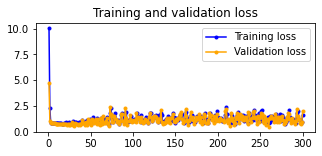

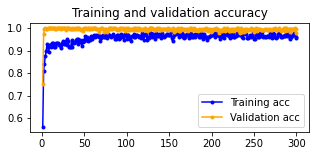

16/16 [==============================] - 0s 955us/step


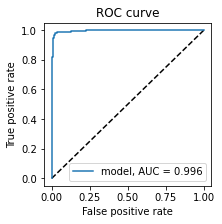

In [24]:
# Plot history and ROC curve
plot_history(history)
plot_roc(model, X_test, Y_test)

In [25]:
### View first layer weights
print(feature_names)
# print("First layer weights:", model.layers[0].get_weights())

['main1', 'main2', 'main3', 'main4', 'main5', 'main6', 'main7', 'main8', 'main9', 'main10', 'main11', 'main12', 'main13', 'main14', 'main15', 'main16', 'main17', 'main18', 'main19', 'main20', 'main21', 'main22', 'main23', 'main24', 'main25', 'main26', 'main27', 'main28', 'main29', 'main30', 'main31', 'main32', 'main33', 'main34', 'main35', 'main36', 'main37', 'main38', 'main39', 'main40', 'main41', 'main42', 'main43', 'main44', 'main45', 'main46', 'main47', 'main48', 'main49', 'main50', 'main51', 'main52', 'main53', 'main54', 'main55', 'main56', 'main57', 'main58', 'main59', 'main60', 'main61', 'main62', 'main63', 'main64', 'main65', 'main66', 'main67', 'main68', 'main69', 'main70', 'main71', 'main72', 'main73', 'main74', 'main75', 'main76', 'main77', 'main78', 'main79', 'main80', 'main81', 'main82', 'main83', 'main84', 'main85', 'main86', 'main87', 'main88', 'main89', 'main90', 'main91', 'main92', 'main93', 'main94', 'main95', 'main96', 'main97', 'main98', 'main99', 'main100', 'main10

In [26]:
### Score features
score_features(model)

Feature importance (highest to lowest)
Feature name	:	RMS value	:	Normalized RMS
main182 	:	 0.018276695 	:	 0.0032270951
main176 	:	 0.017741486 	:	 0.0031325938
main302 	:	 0.016709972 	:	 0.0029504607
main103 	:	 0.016623024 	:	 0.0029351083
main169 	:	 0.015495323 	:	 0.0027359913
main148 	:	 0.015409393 	:	 0.0027208189
main439 	:	 0.015278205 	:	 0.002697655
main138 	:	 0.015271297 	:	 0.0026964352
main134 	:	 0.015140331 	:	 0.002673311
main155 	:	 0.014841683 	:	 0.002620579
main485 	:	 0.014833078 	:	 0.0026190595
var492 	:	 0.014807296 	:	 0.0026145072
main497 	:	 0.014717619 	:	 0.002598673
main215 	:	 0.0144690825 	:	 0.0025547892
var375 	:	 0.014017169 	:	 0.0024749956
main105 	:	 0.013987109 	:	 0.0024696877
var414 	:	 0.013918925 	:	 0.0024576485
var340 	:	 0.013902736 	:	 0.00245479
var460 	:	 0.013901468 	:	 0.0024545663
main24 	:	 0.013885738 	:	 0.0024517889
main28 	:	 0.0136219915 	:	 0.0024052192
var95 	:	 0.013470634 	:	 0.0023784942
main483 	:	 0.013244549 	:	 0.

### Step 4: Drop Some Channels and Train Again

In [27]:
### List features again
print(feature_names)

['main1', 'main2', 'main3', 'main4', 'main5', 'main6', 'main7', 'main8', 'main9', 'main10', 'main11', 'main12', 'main13', 'main14', 'main15', 'main16', 'main17', 'main18', 'main19', 'main20', 'main21', 'main22', 'main23', 'main24', 'main25', 'main26', 'main27', 'main28', 'main29', 'main30', 'main31', 'main32', 'main33', 'main34', 'main35', 'main36', 'main37', 'main38', 'main39', 'main40', 'main41', 'main42', 'main43', 'main44', 'main45', 'main46', 'main47', 'main48', 'main49', 'main50', 'main51', 'main52', 'main53', 'main54', 'main55', 'main56', 'main57', 'main58', 'main59', 'main60', 'main61', 'main62', 'main63', 'main64', 'main65', 'main66', 'main67', 'main68', 'main69', 'main70', 'main71', 'main72', 'main73', 'main74', 'main75', 'main76', 'main77', 'main78', 'main79', 'main80', 'main81', 'main82', 'main83', 'main84', 'main85', 'main86', 'main87', 'main88', 'main89', 'main90', 'main91', 'main92', 'main93', 'main94', 'main95', 'main96', 'main97', 'main98', 'main99', 'main100', 'main10

In [28]:
cols_to_drop = [0,1] 


X_train_dropped = np.delete(X_train, cols_to_drop, axis=1)
X_test_dropped = np.delete(X_test, cols_to_drop, axis=1)

# Update feature list
n_features_dropped = X_train_dropped.shape[1]

# Print shapes
print("New training set shape:", X_train_dropped.shape)
print("New test set shape:", X_test_dropped.shape)

New training set shape: (500, 998)
New test set shape: (500, 998)


In [29]:
### Same model (different L1 values)

# Settings
bias = True
kernel_reg = tf.keras.regularizers.L1(0.001)
bias_reg = tf.keras.regularizers.L1(0.001)
activity_reg = None

# Get dimensions
n_features = X_train_dropped.shape[1]
n_classes = Y_train.shape[1]

# First layer: adjust the regularizers for feature importance
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128,
                                input_dim=n_features, 
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Second layer
model.add(tf.keras.layers.Dense(4,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Output layer
model.add(tf.keras.layers.Dense(n_classes,
                                activation='softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary and first layer weights
print(model.summary())
print("First layer weights:", model.layers[0].get_weights())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               127872    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
 dropout_5 (Dropout)         (None, 4)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
Total params: 128398 (501.55 KB)
Trainable params: 128398 (501.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
First lay

In [30]:
### Train the model

# Settings
batch_size = 10
epochs = 300

# Train
history = model.fit(X_train_dropped, 
                    Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test_dropped, Y_test))

Epoch 1/300


50/50 [==============================] - 1s 8ms/step - loss: 0.5048 - acc: 0.7800 - val_loss: 0.2296 - val_acc: 1.0000
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 0.1976 - acc: 0.9800 - val_loss: 0.0496 - val_acc: 1.0000
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0973 - acc: 0.9920 - val_loss: 0.0225 - val_acc: 1.0000
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0914 - acc: 0.9940 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0829 - acc: 0.9860 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 6/300
50/50 [==============================] - 0s 3ms/step - loss: 0.0796 - acc: 0.9980 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 7/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0813 - acc: 0.9940 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 0.0810 - acc: 0.9900 -

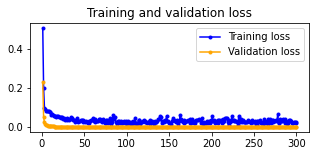

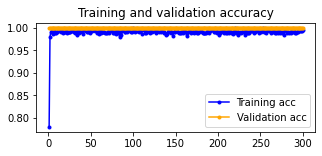

16/16 [==============================] - 0s 1ms/step


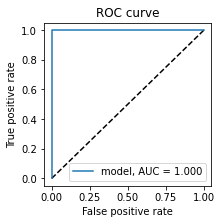

In [31]:
# Plot history and ROC curve
plot_history(history)
plot_roc(model, X_test_dropped, Y_test)

In [32]:
score_features(model)

Feature importance (highest to lowest)
Feature name	:	RMS value	:	Normalized RMS
main20 	:	 0.09881127 	:	 0.0015343641
main371 	:	 0.08821422 	:	 0.0013698107
main447 	:	 0.08566413 	:	 0.0013302123
main380 	:	 0.08476206 	:	 0.0013162047
main104 	:	 0.08434377 	:	 0.0013097094
main431 	:	 0.083948195 	:	 0.0013035669
main64 	:	 0.08354443 	:	 0.0012972972
main353 	:	 0.082313 	:	 0.0012781752
main196 	:	 0.08197982 	:	 0.0012730014
main167 	:	 0.081819504 	:	 0.001270512
var150 	:	 0.08109571 	:	 0.0012592728
main449 	:	 0.08105751 	:	 0.0012586797
main441 	:	 0.081019126 	:	 0.0012580836
var43 	:	 0.080778934 	:	 0.0012543538
main488 	:	 0.080487736 	:	 0.001249832
var434 	:	 0.08046242 	:	 0.0012494389
main46 	:	 0.08038348 	:	 0.0012482131
main455 	:	 0.080078125 	:	 0.0012434715
main69 	:	 0.07969739 	:	 0.0012375594
main136 	:	 0.079273686 	:	 0.00123098
main153 	:	 0.079222366 	:	 0.001230183
main341 	:	 0.07919205 	:	 0.0012297123
main203 	:	 0.07903118 	:	 0.0012272142
main30